# Introduction

- Task : Multi-class Calssificaiton   
- Method : k-Nearest Neighborhood   
- Dataset : CIFAR-10
    - Befor running cells below, place [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) at './data/cifar-10-batches-py/' directory. Structures below :     
        - study-MLDL/data/
            - cifar-10-batches-py
            - batches.meta
            - data_batch_1
            - etc...
        - 1_k-NearestNeighbor.ipynb

# 0. Set Environment

In [1]:
import torch
from torch import Tensor
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
import random

from typing import List, Dict, Tuple, Union, Annotated
from tqdm import tqdm
from pprint import pprint

import pickle
import os

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Selected device:", device)

Selected device: cuda


In [3]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [4]:
data_dir = './data/cifar-10-batches-py/'

In [5]:
import time
import datetime
from functools import wraps

def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time

        time_obj = datetime.timedelta(seconds= int(execution_time))
        
        print(f"Function '{func.__name__}' Execution Time {time_obj}")
        return result
    return wrapper

# 1. Process Data

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data_dir: str, train: bool = True) -> None:
        self.data_dir = data_dir
        self.train = train

        self.data = torch.empty((0, 3072), dtype=torch.uint8)
        self.label = torch.empty((0,), dtype=torch.uint8)

        self._fileloader()

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[Annotated[Tensor, 'data_size, input_dim', 'dtype= torch.uint8'],
                                             Annotated[Tensor, 'data_size', 'dtype= torch.uint8']]:
        return self.data[idx], self.label[idx]
    
    def _fileloader(self) -> None:
        import os
        filestart = 'data_batch' if self.train else 'test_batch'
        file_paths = [os.path.join(self.data_dir, f) for f in os.listdir(self.data_dir) if f.startswith(filestart)]

        for file_path in file_paths:
            self._load_and_merge(file_path)
                    
    def _unpickle(self, data_dir: str) -> Dict:
        import pickle
        with open(data_dir, 'rb') as fo:
            return pickle.load(fo, encoding='bytes')
            
    def _load_and_merge(self, file_path: str) -> None:
        file_data = self._unpickle(file_path)
        
        # data: Tensor, 'data_size, input_dim', 'dtype= torch.uint8'
        # label: Tensor, 'data_size', 'dtype= torch.uint8'
        data = torch.tensor(file_data[b'data'], dtype=torch.uint8)
        label = torch.tensor(file_data[b'labels'], dtype=torch.uint8)

        self.data = torch.cat((self.data, data), dim=0)
        self.label = torch.cat((self.label, label), dim=0)

In [7]:
train_dataset = CustomDataset(data_dir= data_dir, 
                              train= True)
test_dataset = CustomDataset(data_dir= data_dir, 
                             train= False)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
batch_size = 4
shuffle = True

trainloader = DataLoader(dataset = train_dataset,
                         batch_size = batch_size,
                         shuffle = shuffle)
testloader = DataLoader(dataset = test_dataset,
                        batch_size = batch_size,
                        shuffle = shuffle)

In [9]:
def reformat_image(image: Annotated[Tensor, '3*32*32','dtype= torch.uint8']) -> Annotated[Tensor, '32, 32 3', 'dtype= torch.uint8']:
    image = image.reshape((3, 32, 32)).permute((1, 2, 0))
    return image

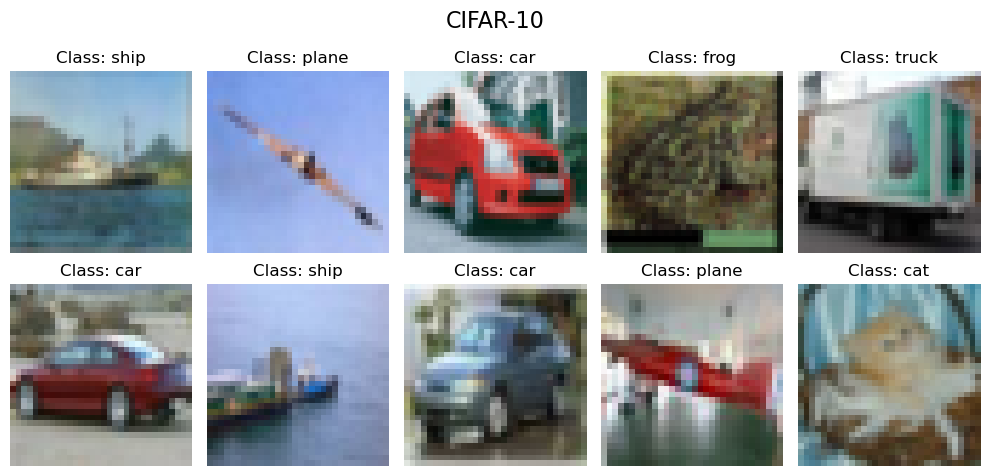

In [10]:
plt.figure(figsize=(10, 5))
plt.suptitle('CIFAR-10', fontsize=16)
for i in range(10):
    random_idx = random.randint(0, len(train_dataset) - 1)
    sample_image = reformat_image(train_dataset[random_idx][0])
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_image)
    plt.axis('off')
    plt.title(f'Class: {classes[train_dataset[random_idx][1].item()]}')
plt.tight_layout() 
plt.show()

# 2. Define Model

In [11]:
class NearestNeighborClassifier():
    def __init__(self,
                 distance: str = 'L1',
                 device = device) -> None:
        
        assert distance in ['L1', 'L2'], "Distance should be 'L1' or 'L2'"
        self.distance = distance

        self.device = device

    @timeit
    def train(self, 
              train_dataset: CustomDataset) -> None:
        # self.Xtr: Tensor, 'train_size, input_dim'
        # self.Ytr: Tensor, 'train_size'
        self.Xtr = train_dataset[:][0].to(self.device)
        self.Ytr = train_dataset[:][1].to(self.device)

    def predict(self,
                X: Annotated[Tensor, 'data_size, input_dim', 'dtype= torch.uint8'],
                Y: Annotated[Tensor, 'data_size', 'dtype= torch.uint8'],
                k: int)                                                        -> Tuple[Annotated[Tensor, 'data_size, k, input_dim', 'dtype= torch.uint8'],
                                                                                        Annotated[Tensor, 'data_size', 'dtype= torch.uint8']]:
        X = X.to(self.device)
        Y = Y.to(self.device)

        data_size = X.shape[0]
        input_dim = X.shape[1]
        
        # distances: Tensor, 'data_size, train_size', 'dtype= torch.uint8'
        if self.distance == 'L1':
            distances = torch.sum(torch.abs(self.Xtr - X[:, None, :]), dim=2)
        else:  # 'L2'
            distances = torch.sqrt(torch.sum((self.Xtr - X[:, None, :])**2, dim=2))
        
        # nearest_indices: Tensor, 'data_size, k', 'dtype= torch.int64'
        # nearest_labels: Tensor, 'data_size, k', 'dtype= torch.int64'
        _, nearest_indices = torch.topk(distances, k, dim=1, largest=False)
        nearest_labels = self.Ytr[nearest_indices]

        # Xpred: Tensor, 'data_size, k, input_dim', 'dtype= torch.uint8'
        # Ypred: Tensor, 'data_size', 'dtype= torch.uint8'
        Xpred = self.Xtr[nearest_indices].to(self.device)
        Ypred = torch.tensor([Counter(nearest_labels[i].tolist()).most_common(1)[0][0] for i in range(data_size)], dtype= torch.uint8).to(self.device)

        return Xpred, Ypred
    
    @timeit
    def evaluate(self, 
                 testloader: DataLoader,
                 k: int = 3) -> float:

        results = []
        for (data, label) in tqdm(testloader):
            # Xte: Tensor, 'batch_size, input_dim', 'dtype= torch.uint8'
            # Yte: Tensor, 'batch_size', 'dtype= torch.uint8'
            Xte = data.to(self.device)
            Yte = label.to(self.device)

            # Ypred: Tensor, 'batch_size', 'dtype= torch.uint8'
            _, Ypred = self.predict(Xte, Yte, k)

            results.append(Yte == Ypred)

        # results: Tensor, 'test_size'
        # acc: float
        results = torch.cat(results)
        acc = torch.mean(results.float()).item()

        return acc
    
    def visualize_topk(self,
                        data: Tuple[Annotated[Tensor, 'data_size, input_dim', 'dtype= torch.uint8'],
                                    Annotated[Tensor, 'data_size', 'dtype= torch.uint8']],
                        k: int = 10) -> None:
        X, Y = data
        data_size = X.shape[0]

        Xpred = torch.zeros(data_size, k, 3072, dtype= torch.uint8)
        Ypred = torch.zeros(data_size, dtype= torch.uint8)

        for i in range(data_size):
            X_example = X[i, :].unsqueeze(0)
            Y_example = Y[i].unsqueeze(0)

            Xpred[i, :, :], Ypred[i] = self.predict(X_example, Y_example, k)
        
        plt.figure()
        plt.suptitle('Nearest Images')
        for i in range(data_size):
            original_image = reformat_image(X[i, :])
            plt.subplot(data_size, k+1,  i*(k+1)+1) 
            plt.imshow(original_image)
            plt.axis('off')
            plt.title(f'Original Class: {classes[Y[i]]} | Nearest Class: {classes[Ypred[i]]}', fontsize=5)

            for kth in range(k):
                kth_image = reformat_image(Xpred[i, kth, :])
                plt.subplot(data_size, k+1,  i*(k+1)+kth+2)
                plt.imshow(kth_image)
                plt.axis('off')
        plt.tight_layout()
        plt.show()

# 3. Train

In [12]:
model = NearestNeighborClassifier(distance= 'L2')

In [13]:
model.train(train_dataset)

Function 'train' Execution Time 0:00:00


# 4. Test

In [14]:
acc = model.evaluate(testloader)
print(f'Accuracy : {acc:.3f}')

100%|██████████| 2500/2500 [01:10<00:00, 35.64it/s]

Function 'evaluate' Execution Time 0:01:10
Accuracy : 0.246


# 5. Inference

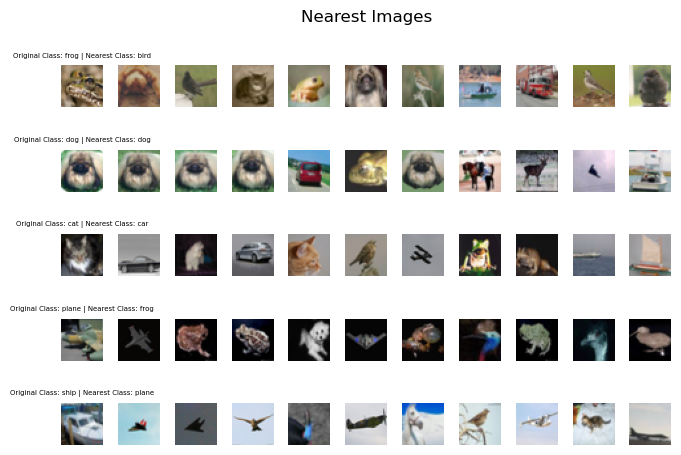

In [15]:
random_idx = random.randint(0, 10000-5)
model.visualize_topk(test_dataset[random_idx:random_idx+5], k= 10)